# Adversarial-Robustness-Toolbox for scikit-learn Support Vector Machines SVC and LinearSVC

In [1]:
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

from art.classifiers import SklearnClassifier
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1 Training scikit-learn SVC/LinearSVC and attacking with ART Projected Gradient Descent

In [2]:
def get_adversarial_examples(x_train, y_train, kernel, model_type=None):
    
    # Create and fit LinearSVC or SVC
    if model_type == 'LinearSVC':
        model = LinearSVC()
    else:
        model = SVC(C=1.0, kernel=kernel, degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, 
                    tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
                    decision_function_shape='ovr', random_state=None)
    model.fit(X=x_train, y=y_train)
    #  Create ART classfier for scikit-learn SVC
    art_classifier = SklearnClassifier(model=model, clip_values=(0, 10))
    print(art_classifier)
    
    
    # Create ART Projected Gradient Descent attack
    pgd = ProjectedGradientDescent(classifier=art_classifier, norm=1, eps=1.0, eps_step=0.1, max_iter=10,
                                   targeted=False, num_random_init=0, batch_size=1)

    # Generate adversarial samples with ART Projected Gradient attack
    x_train_adv = pgd.generate(x_train)

    return x_train_adv, model

## 1.1 Utility functions

In [3]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] -= 2
    x_train[:, 1][y_train == 2] += 2
    return x_train, y_train

In [4]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type=None):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        if model_type is None:
            # Mark support vectors with circles
            for sv in model.support_vectors_:
                axs[i_class].scatter(sv[0], sv[1], s=200, linewidth=3, facecolors='none', edgecolors='lightgreen',
                                     zorder=2)

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 1.5, 8.5
        y_min, y_max = 0, 7

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        if model_type is None and model.probability:
            Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
            Z_proba = Z_proba[:, i_class].reshape(xx.shape)
            im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                       vmin=0, vmax=1)
            if i_class == num_classes - 1:
                cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
                plt.colorbar(im, ax=axs[i_class], cax=cax)
        else:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i_class].contour(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot adversarial samples
        axs[i_class].scatter(x_train_adv[y_train == i_class][:, 0], x_train_adv[y_train == i_class][:, 1], zorder=2,
                             c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')


# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- light green circles: support vectors
- red crosses: adversarial samples for class i

## 2.1 LinearSVC, binary classification

ScikitlearnSVC(model=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), nb_classes=2, preprocessing=(0, 1), input_shape=None, defences=None, clip_values=(0, 10))


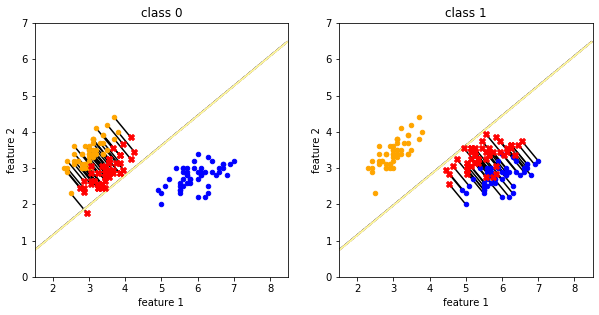

In [5]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='linear', model_type='LinearSVC')
plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type='LinearSVC')

ScikitlearnSVC(model=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), nb_classes=2, preprocessing=(0, 1), input_shape=None, defences=None, clip_values=(0, 10))


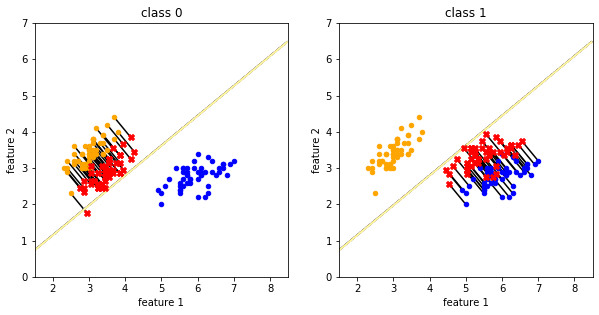

In [6]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='linear', model_type='LinearSVC')
plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type='LinearSVC')

## 2.2 LinearSVC, multi-classification

ScikitlearnSVC(preprocessing=(0, 1), nb_classes=3, input_shape=None, model=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), defences=None, clip_values=(0, 10))


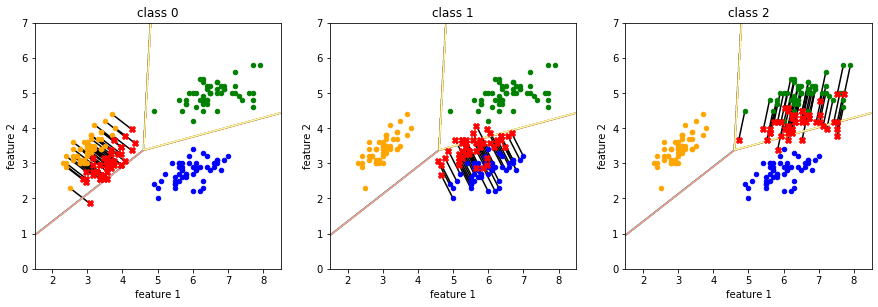

In [7]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='linear', model_type='LinearSVC')
plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type='LinearSVC')

## 2.3 SVC, linear kernel, binary classification

ScikitlearnSVC(nb_classes=2, preprocessing=(0, 1), input_shape=None, model=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), defences=None, clip_values=(0, 10))


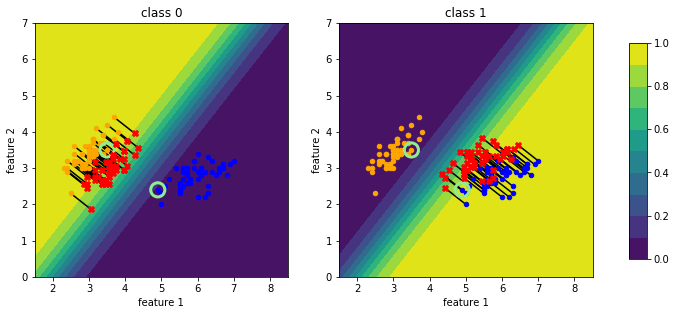

In [8]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='linear')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.4 SVC, linear kernel, multi-classification

ScikitlearnSVC(model=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), preprocessing=(0, 1), input_shape=None, nb_classes=3, defences=None, clip_values=(0, 10))


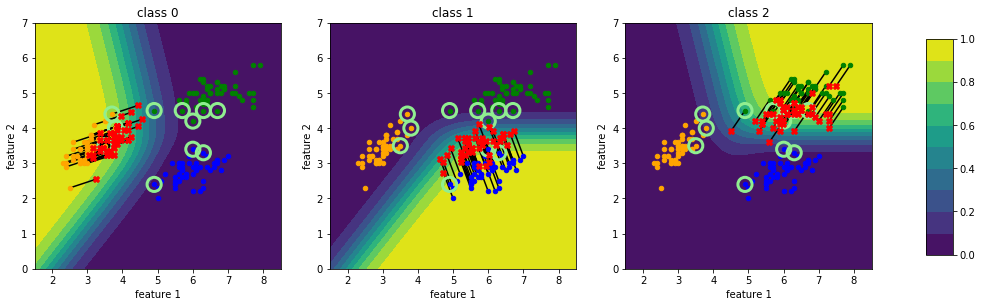

In [9]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='linear')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.5 SVC, rbf kernel, binary classification

ScikitlearnSVC(model=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), nb_classes=2, preprocessing=(0, 1), input_shape=None, defences=None, clip_values=(0, 10))


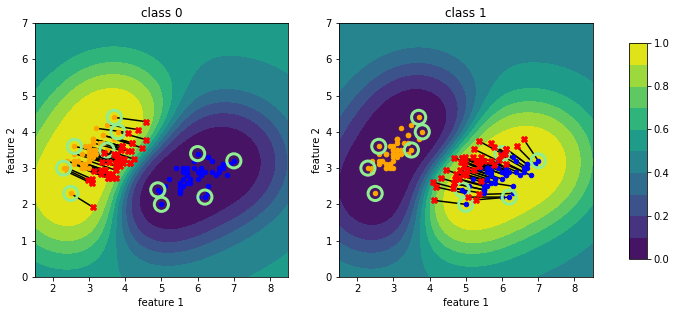

In [10]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.6 SVC, rbf kernel, multi-classification

ScikitlearnSVC(preprocessing=(0, 1), nb_classes=3, input_shape=None, model=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), defences=None, clip_values=(0, 10))


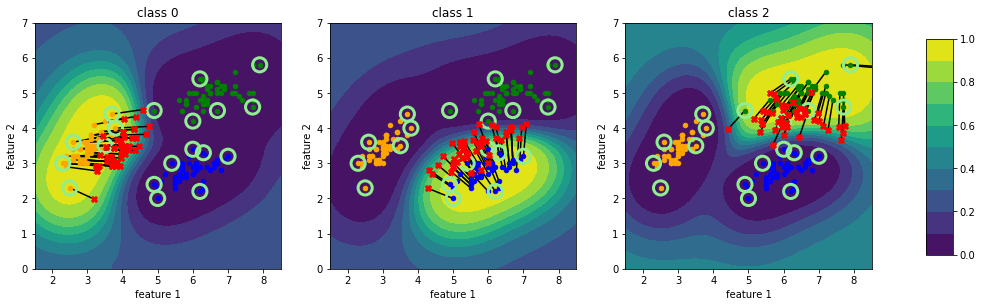

In [11]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

# 3 Example: MNIST

## 3.1 Load and transform MNIST dataset

In [12]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

## 3.2 Train SVC classifier

In [13]:
model = SVC(C=1.0, kernel='linear', probability=True)

In [14]:
model.fit(X=x_train, y=y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## 3.3 Create and apply ProjectedGradientDescent Attack with ART

In [15]:
art_classifier = SklearnClassifier(model=model)

In [16]:
pgd = ProjectedGradientDescent(classifier=art_classifier, norm=np.inf, eps=.2, eps_step=0.1, max_iter=2, 
                               targeted=False, num_random_init=0, batch_size=128)

In [17]:
x_train_adv = pgd.generate(x_train)

In [18]:
x_test_adv = pgd.generate(x_test)

## 3.4 Evaluate SVC classifier on benign and adversarial samples

In [19]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


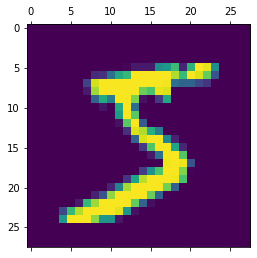

In [20]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [21]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [22]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.1250


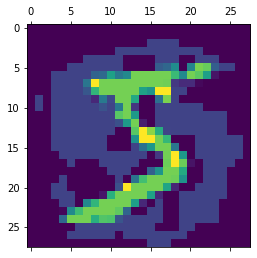

In [23]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [24]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 3


In [25]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7650


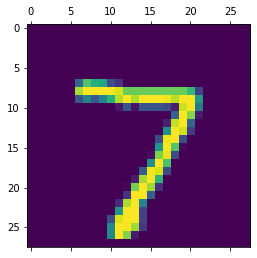

In [26]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [27]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [28]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.1250


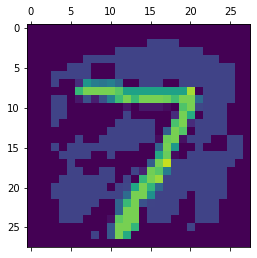

In [29]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [30]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 9


## 3.5 Investigate dependence on attack budget eps

(0, 1)

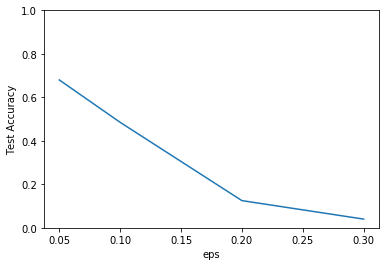

In [31]:
eps_list = [0.05, 0.1, 0.2, 0.3]
score_list = list()

for eps in eps_list:
    pgd = ProjectedGradientDescent(classifier=art_classifier, norm=np.inf, eps=eps, eps_step=0.01, max_iter=60, 
                                   targeted=False, num_random_init=0, batch_size=128)
    x_test_adv = pgd.generate(x_test)
    score = model.score(x_test_adv, y_test)
    score_list.append(score)

plt.plot(eps_list, score_list)
plt.xlabel('eps')
plt.ylabel('Test Accuracy')
plt.ylim((0, 1))

## 3.6 Targeted PGD attack

In [32]:
pgd = ProjectedGradientDescent(classifier=art_classifier, norm=np.inf, eps=0.5, eps_step=0.01, max_iter=20, 
                               targeted=True, num_random_init=3, batch_size=128)
y_test_target = np.zeros((y_test.shape[0], 10))
target_label = 7
y_test_target[:, target_label] = 1
x_test_adv = pgd.generate(x_test, y=y_test_target)
score = model.score(x_test_adv, y_test)

In [33]:
score = model.score(x_test_adv, np.argmax(y_test_target, axis=1))
print("Targeted Benign Test Score: %.4f" % score)

Targeted Benign Test Score: 0.5850


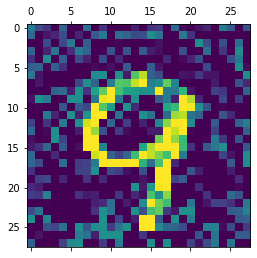

In [34]:
plt.matshow(x_test_adv[16, :].reshape((28, 28)))
plt.clim(0, 1)

In [35]:
prediction = model.predict(x_test_adv[16:17, :])[0]
print("Target Label: %i" % target_label)
print("Predicted Label: %i" % prediction)

Target Label: 7
Predicted Label: 7
